In [11]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score


In [12]:
def load_data_from_files(file_names, data_path='dataset/'):
    df_list = []
    for file_name in file_names:
        file_path = os.path.join(data_path, file_name)
        try:
            df = pd.read_csv(file_path, encoding='latin1', low_memory=False, on_bad_lines='skip')
            df.columns = df.columns.str.strip()
            df_list.append(df)
            print(f"'{file_name}' 파일 로드 완료. ({len(df)} rows)")
        except Exception as e:
            print(f"'{file_name}' 파일을 읽는 중 오류 발생: {e}")
            continue
    if not df_list:
        print("로드된 데이터가 없습니다.")
        return pd.DataFrame()
    full_df = pd.concat(df_list, ignore_index=True)
    print("-" * 50)
    print(f"총 {len(df_list)}개 파일 로드 완료. 전체 행 수: {len(full_df)}")
    return full_df

In [13]:
def convert_ip2int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except ValueError:
        return 0  # Return 0 for invalid IP addresses    

def preprocess_data(data):
    df = data.copy()
    df.columns = df.columns.str.strip().str.replace('[ /]', '_', regex=True)
    
    df['Source_IP'] = df['Source_IP'].apply(convert_ip2int)
    df['Destination_IP'] = df['Destination_IP'].apply(convert_ip2int)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce').astype(np.int64)

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    y = np.where(df['Label'] == 'BENIGN', 0, 1)
    X = df.drop('Label', axis=1)
    X = X.select_dtypes(include=np.number)
    return X, y
# 위의 과정을 통해 Flow ID라는 int 형태가 될 수 없는 데이터와
# y로 분리되어 있는 Label을 제외한 나머지 데이터는 모두 숫자형으로 변환된다.


In [14]:
# --- 1. 테스트 데이터 준비 --- 
DATASET_PATH = 'dataset/'
all_csv_files = [f for f in os.listdir(DATASET_PATH) if f.endswith('.csv')]

# 테스트용 파일(수요일 제외)만 로드
test_file_names = [f for f in all_csv_files if 'Wednesday' not in f]

print("--- 테스트 데이터 로드 ---")
test_df_raw = load_data_from_files(test_file_names, data_path=DATASET_PATH)


--- 테스트 데이터 로드 ---
'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv' 파일 로드 완료. (225745 rows)
'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv' 파일 로드 완료. (286467 rows)
'Friday-WorkingHours-Morning.pcap_ISCX.csv' 파일 로드 완료. (191033 rows)
'Monday-WorkingHours.pcap_ISCX.csv' 파일 로드 완료. (529918 rows)
'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv' 파일 로드 완료. (288602 rows)
'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv' 파일 로드 완료. (458968 rows)
'Tuesday-WorkingHours.pcap_ISCX.csv' 파일 로드 완료. (445909 rows)
--------------------------------------------------
총 7개 파일 로드 완료. 전체 행 수: 2426642


In [15]:
X_test, y_test = preprocess_data(test_df_raw.copy())

print(f"전처리 후 테스트 데이터 형태: {X_test.shape}")

전처리 후 테스트 데이터 형태: (2426642, 83)


'models/rf_model_full.pkl'에서 모델을 불러옵니다...
모델 불러오기 성공.
모델이 학습한 특성 수: 83
테스트 데이터의 특성을 모델에 맞게 정렬했습니다.
--- 사전 학습된 RandomForest 모델 성능 평가 ---
정확도 (Accuracy): 0.7941\n
분류 리포트 (Classification Report):
              precision    recall  f1-score   support

  BENIGN (0)       0.79      1.00      0.88   1833066
  ATTACK (1)       1.00      0.16      0.27    593576

    accuracy                           0.79   2426642
   macro avg       0.89      0.58      0.58   2426642
weighted avg       0.84      0.79      0.73   2426642



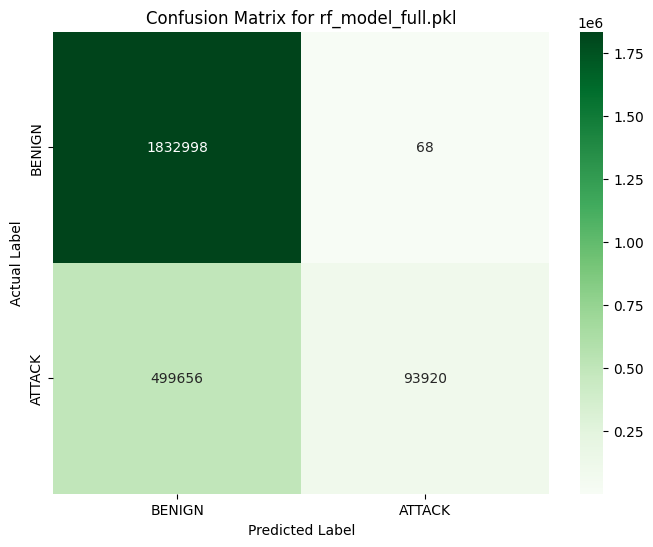

In [ ]:
# --- 3. 저장된 RandomForest 모델 불러오기 및 평가 ---
MODEL_PATH = 'models/rf_model_full.pkl'

try:
    print(f"'{MODEL_PATH}'에서 모델을 불러옵니다...")
    rf_model = joblib.load(MODEL_PATH)
    print("모델 불러오기 성공.")
    
    # --- 특성 일치시키기 (매우 중요) ---
    # 모델이 학습된 특성 순서를 가져옵니다.
    model_features = rf_model.feature_names_in_
    print(f"모델이 학습한 특성 수: {len(model_features)}")
    
    # 테스트 데이터의 컬럼을 모델의 특성 순서와 일치시킵니다.
    X_test_aligned = X_test[model_features]
    print("테스트 데이터의 특성을 모델에 맞게 정렬했습니다.")
    
    # --- 예측 및 평가 ---
    print("--- 사전 학습된 RandomForest 모델 성능 평가 ---")
    y_pred = rf_model.predict(X_test_aligned)
    
    print(f"정확도 (Accuracy): {accuracy_score(y_test, y_pred):.4f}")
    print("분류 리포트 (Classification Report):")
    print(classification_report(y_test, y_pred, target_names=['BENIGN (0)', 'ATTACK (1)']))
    
    # 혼동 행렬 (Confusion Matrix) 시각화
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
    plt.title(f'Confusion Matrix for {os.path.basename(MODEL_PATH)}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

except FileNotFoundError:
    print(f"오류: 모델 파일 '{MODEL_PATH}'을(를) 찾을 수 없습니다.")
except AttributeError:
    print("오류: 불러온 모델에서 특성 이름 정보(feature_names_in_)를 찾을 수 없습니다. 모델이 scikit-learn 1.0 미만 버전으로 저장되었을 수 있습니다.")
except KeyError as e:
    print(f"오류: 테스트 데이터에 모델이 필요로 하는 특성이 없습니다: {e}. 학습과 테스트 시 사용된 특성이 다른지 확인하세요.")
except Exception as e:
    print(f"모델 평가 중 오류 발생: {e}")

Text(0.5, 1.0, 'ROC Curve')

c:\Users\jalna\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  func(*args, **kwargs)
c:\Users\jalna\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 52404 (\N{HANGUL SYLLABLE CE}) missing from current font.
  func(*args, **kwargs)
c:\Users\jalna\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 53945 (\N{HANGUL SYLLABLE TEUG}) missing from current font.
  func(*args, **kwargs)
c:\Users\jalna\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  func(*args, **kwargs)
c:\Users\jalna\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig

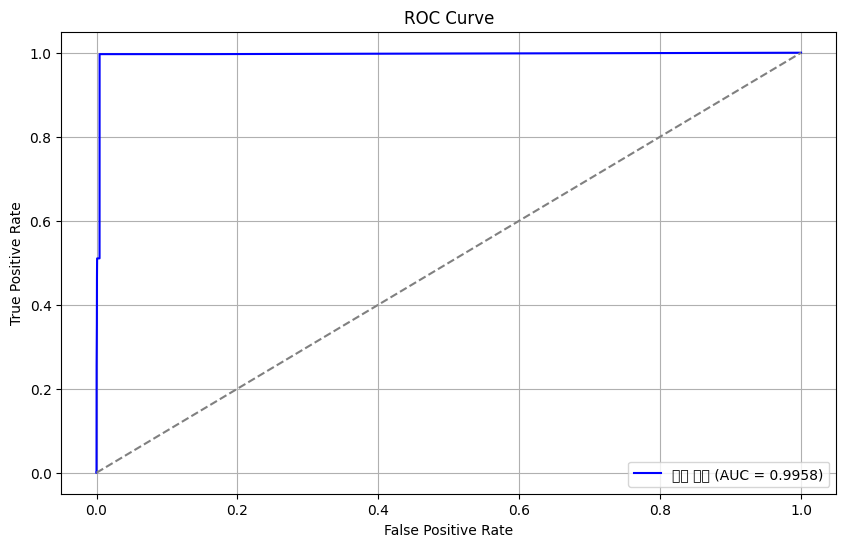

In [18]:
# --- 4. RoC 및 AUC 계산 ---
from sklearn.metrics import roc_curve, auc

y_scores_full = rf_model.predict_proba(X_test)[:, 1]

fpr_full, tpr_full, _ = roc_curve(y_test, y_scores_full)
roc_auc_full = auc(fpr_full, tpr_full)

plt.figure(figsize=(10, 6))
plt.plot(fpr_full, tpr_full, color='blue', label=f'전체 특성 (AUC = {roc_auc_full:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.legend()
plt.grid()
plt.title('ROC Curve')